In [4]:
import collections
import os
import sys
import tarfile
import tempfile
import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

# Needed to show segmentation colormap labels
DEEPLAB_PATH = 'deeplab'
sys.path.append(DEEPLAB_PATH+'/utils')
import get_dataset_colormap

In [5]:
_FROZEN_GRAPH_NAME = 'frozen_inference_graph'


class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        
        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if _FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()
        
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():      
            tf.import_graph_def(graph_def, name='')
        
        self.sess = tf.Session(graph=self.graph)
            
    def run(self, image):
        """Runs inference on a single image.
        
        Args:
            image: A PIL.Image object, raw input image.
            
        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map


In [6]:
model_dir = 'models'
_TARBALL_NAME = 'deeplab_model.tar.gz'
download_path = os.path.join(model_dir, _TARBALL_NAME)
model = DeepLabModel(download_path)

In [17]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
    'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = get_dataset_colormap.label_to_color_image(FULL_LABEL_MAP)


def vis_segmentation(image, seg_map):
    plt.figure(figsize=(20, 20))
    grid_spec = gridspec.GridSpec(2, 2)
    
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
        
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)
    
    plt.subplot(grid_spec[1])
    seg_image = Image.fromarray(np.uint8(seg_image))            
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
#    return output_image
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0)

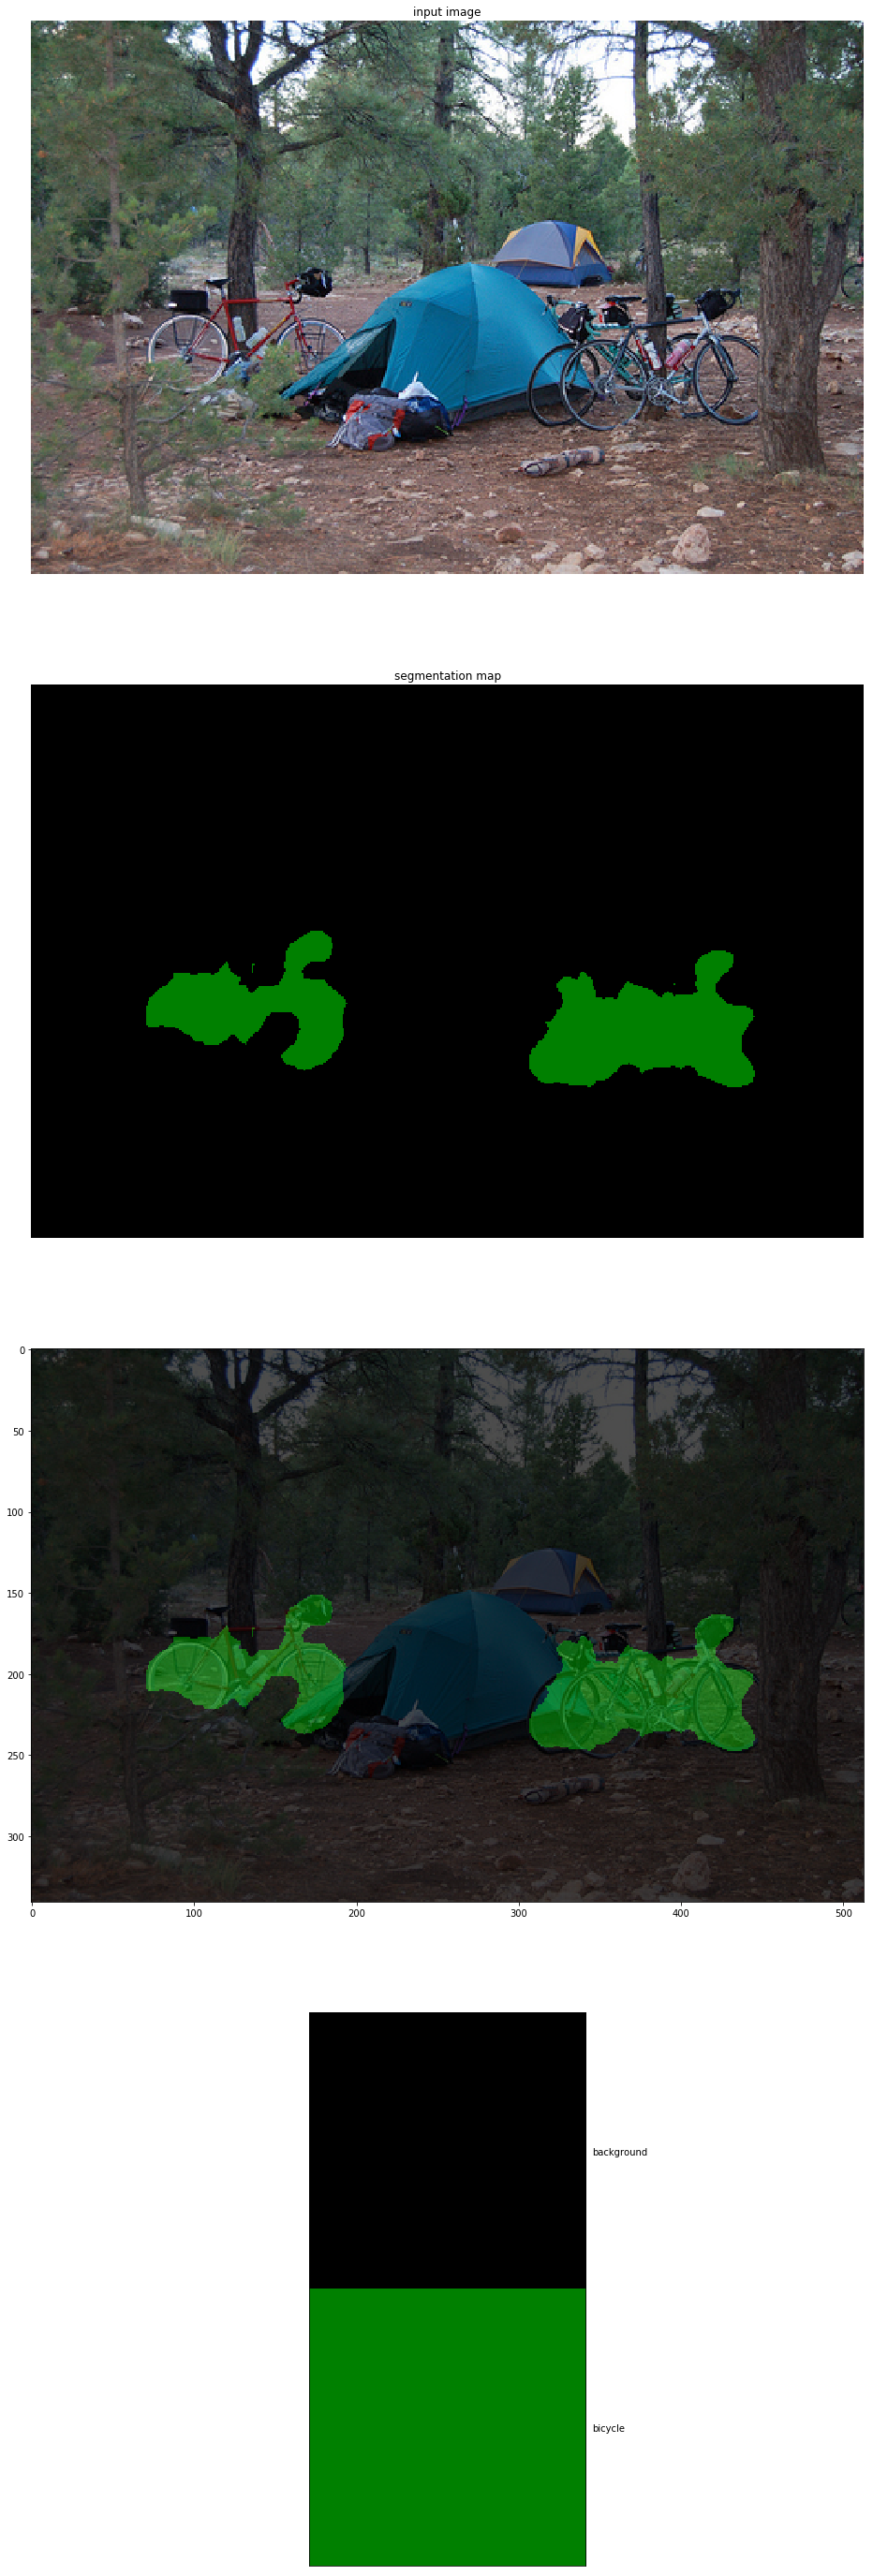

In [12]:
image_path = 'data/test4.jpg'
orignal_im = Image.open(image_path)
resized_im, seg_map = model.run(orignal_im)


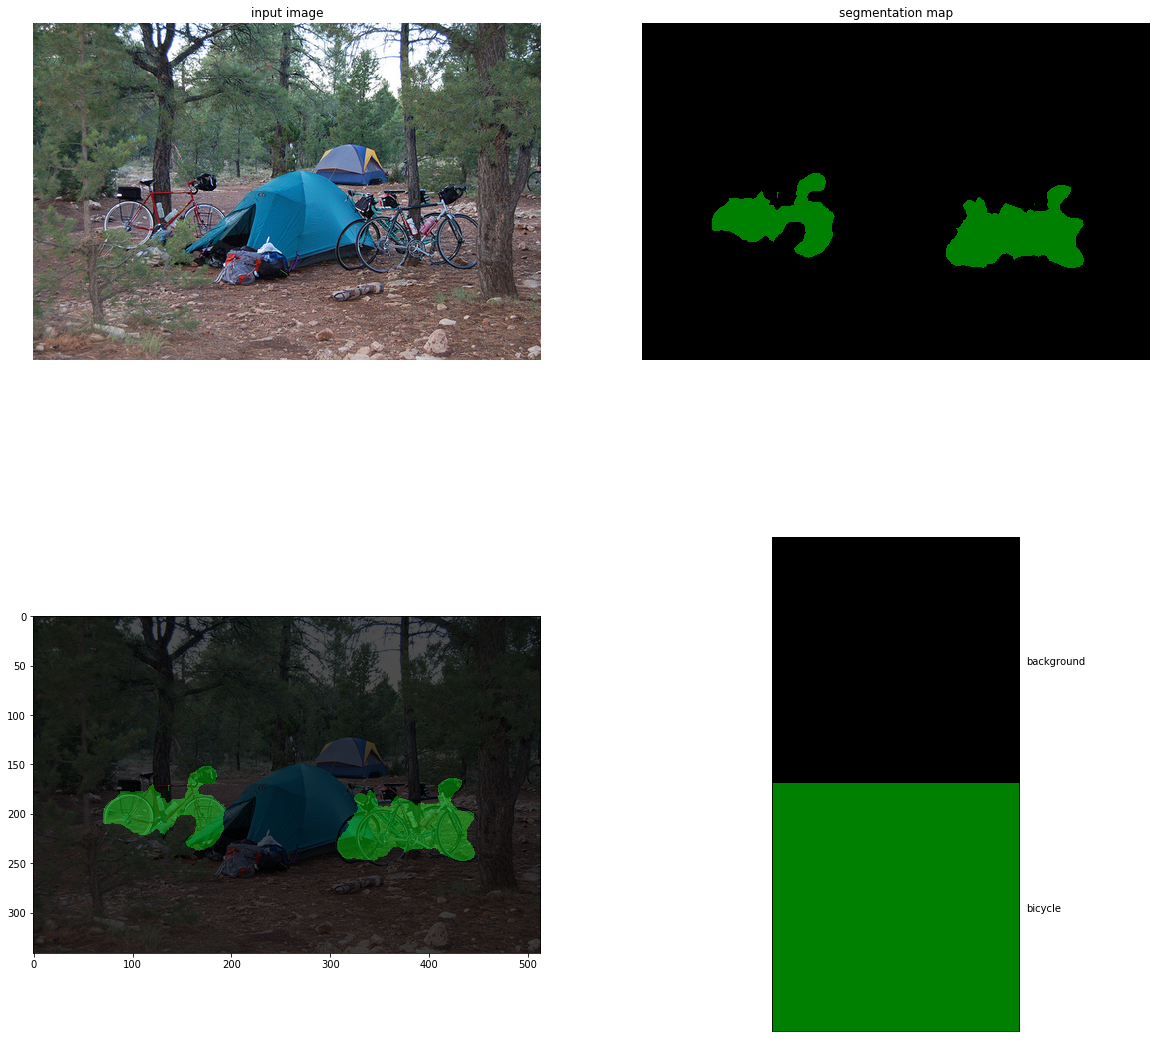

In [18]:
vis_segmentation(resized_im, seg_map)